# Project 4: West Nile Virus Classifer (Part 2)
---

Collaborators from the class of DSIF-11-SG (Jun '23 - Dec '23):
1. Liyena Yusof
2. Maimunah Iskhander
3. Marko Lim
4. Tiffany Tan

---
## Contents
1. [Modelling](#1.0-Modelling)<br>
2. [Findings and conclusion](#2.0-Findings-and-conclusion)
---

# 1.0 Modelling

## 1.1 Import Libraries

In [128]:
# Basic Library 
import pandas as pd

# Basic visualization tools 
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn library
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, make_scorer, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Imbalance library 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

# Lightgbm
from lightgbm import LGBMClassifier

# Xgboost
from xgboost import XGBClassifier

## 1.2 Import and Prepare Datasets

In [2]:
merge_train = pd.read_csv('../datasets/encoded_train.csv')
merge_test = pd.read_csv('../datasets/encoded_test.csv')

In [3]:
merge_train.columns

Index(['species', 'trap', 'latitude', 'longitude', 'addressaccuracy', 'block',
       'nummosquitos', 'wnvpresent', 'street', 'day', 'month', 'year', 'week',
       'dayofweek', 'tmax', 'tmin', 'tavg', 'wetbulb', 'heat', 'cool',
       'sunrise', 'sunset', 'stnpressure', 'sealevel', 'resultspeed',
       'resultdir', 'avgspeed', 'precipbool', 'direction', 'winddir'],
      dtype='object')

In [4]:
merge_test.columns

Index(['id', 'species', 'block', 'street', 'trap', 'latitude', 'longitude',
       'addressaccuracy', 'day', 'month', 'year', 'week', 'dayofweek', 'tmax',
       'tmin', 'tavg', 'wetbulb', 'heat', 'cool', 'sunrise', 'sunset',
       'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed',
       'precipbool', 'direction', 'winddir'],
      dtype='object')

In [5]:
# Columns that are only in merge_train and not in merge_test
unique_train_cols = set(merge_train.columns) - set(merge_test.columns)
unique_train_cols

{'nummosquitos', 'wnvpresent'}

In [6]:
# Columns that are only in merge_test and not in merge_train
unique_test_cols = set(merge_test.columns) - set(merge_train.columns)
unique_test_cols

{'id'}

In [7]:
# Rearrange the columns

common_cols = set(merge_test.columns) - unique_test_cols
merge_train = merge_train[list(common_cols) + list(unique_train_cols)]

In [8]:
# Drop 'street' in merge_test

merge_test.drop(columns='street', inplace=True)

## 1.3 Define X and y

In [9]:
X = merge_train.drop(columns=['wnvpresent', 'nummosquitos', 'street'])

In [10]:
y = merge_train['wnvpresent']

## 1.4 Train-Test-Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## 1.5 Create Functions for Modeling

### 1.5.1 Create a function to run gridsearch

In [12]:
def run_grid_search(pipeline, param_grid, X_train, y_train):
    grid_search = GridSearchCV(pipeline, param_grid, cv=KFold(10), verbose=1, n_jobs=-1, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    return grid_search

### 1.5.2 Define Generic Pipeline for Modeling

In [13]:
# Define pipeline with placeholders

pipeline = ImbPipeline([
    ('ss', StandardScaler()), 
    ('smotetomek', SMOTETomek(random_state=42)),
    ('clf', LogisticRegression()) 
])

### 1.5.3 Function to Compute ROC-AUC Scores

In [100]:
# Generate ROC_AUC scores

def roc_auc(model):
    y_train_prob = model.predict_proba(X_train)[:, 1]
    roc_auc_train = roc_auc_score(y_train, y_train_prob)

    y_test_prob = model.predict_proba(X_test)[:, 1]
    roc_auc_test = roc_auc_score(y_test, y_test_prob)

    print("ROC-AUC for Train:", roc_auc_train)
    print("ROC-AUC for Test:", roc_auc_test)

### 1.5.4 Function to Generate Classification Reports

In [101]:
# Generate Classifcation Reports

def report(model):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print("Classification Report for Train:\n", classification_report(y_train, y_train_pred))
    print("======================================================\n")
    print("Classification Report for Test:\n", classification_report(y_test, y_test_pred))

### 1.5.5 Function to Generate Confusion Matrix Plots

In [111]:
def cmplot(model):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    cm_train = confusion_matrix(y_train, y_train_pred, labels=model.named_steps['clf'].classes_)
    cm_test = confusion_matrix(y_test, y_test_pred, labels=model.named_steps['clf'].classes_)

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=model.named_steps['clf'].classes_)
    disp_train.plot(ax=ax[0], cmap=plt.cm.Reds)
    ax[0].set_title('Confusion Matrix for Train Set')
    ax[0].set_xlabel('Predicted WNV')
    ax[0].set_ylabel('Actual WNV')
    ax[0].set_xticks(ticks=[0, 1], labels=['absent', 'present'])
    ax[0].set_yticks(ticks=[0, 1], labels=['absent', 'present'])

    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=model.named_steps['clf'].classes_)
    disp_test.plot(ax=ax[1], cmap=plt.cm.Blues)
    ax[1].set_title('Confusion Matrix for Test Set')
    ax[1].set_xlabel('Predicted WNV')
    ax[1].set_ylabel('Actual WNV')
    ax[1].set_xticks(ticks=[0, 1], labels=['absent', 'present'])
    ax[1].set_yticks(ticks=[0, 1], labels=['absent', 'present'])

    plt.tight_layout()
    plt.show()

## 1.6.0 Modeling 

### 1.6.1 Logistic Regression

In [14]:
# Define parameter grid

param_grid_logreg = {
    'clf': [LogisticRegression(max_iter = 10000, solver='saga')],
    'clf__C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
    'clf__penalty': ['l1', 'l2']
}

In [15]:
%time
# Run grid search

grid_search_logreg = run_grid_search(pipeline, param_grid_logreg, X_train, y_train)
print("Best parameters for Logistic Regression:", grid_search_logreg.best_params_)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best parameters for Logistic Regression: {'clf': LogisticRegression(C=0.5, max_iter=10000, solver='saga'), 'clf__C': 0.5, 'clf__penalty': 'l2'}


In [16]:
# Save the model

LR = grid_search_logreg.best_estimator_

In [89]:
# Generate ROC_AUC scores

roc_auc(LR)

ROC-AUC for Train: 0.7962908722380613
ROC-AUC for Test: 0.7986299458167235


In [102]:
# Generate Classifcation Reports

report(LR)

Classification Report for Train:
               precision    recall  f1-score   support

           0       0.98      0.68      0.80      5612
           1       0.12      0.75      0.20       320

    accuracy                           0.68      5932
   macro avg       0.55      0.71      0.50      5932
weighted avg       0.93      0.68      0.77      5932


Classification Report for Test:
               precision    recall  f1-score   support

           0       0.98      0.70      0.81      2406
           1       0.12      0.76      0.21       137

    accuracy                           0.70      2543
   macro avg       0.55      0.73      0.51      2543
weighted avg       0.93      0.70      0.78      2543



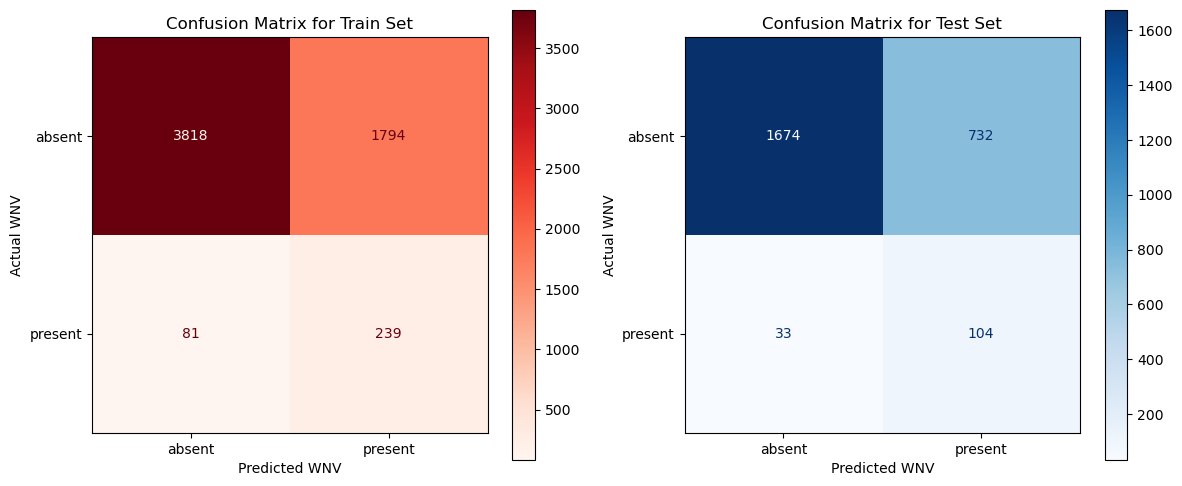

In [112]:
# Plot Confusion Matrix (Train and Test)

cmplot(LR)

### 1.6.2 Gaussian Naive Bayes

In [20]:
# Define parameter grid

param_grid_nb = {
    'clf': [GaussianNB()],
    'clf__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
}

In [21]:
%time
# Run grid search

grid_search_nb = run_grid_search(pipeline, param_grid_nb, X_train, y_train)
print("Best parameters for Gaussian Naive Bayes:", grid_search_nb.best_params_)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 4.05 µs
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Best parameters for Gaussian Naive Bayes: {'clf': GaussianNB(var_smoothing=0.001), 'clf__var_smoothing': 0.001}


In [22]:
# Save the model

NB = grid_search_nb.best_estimator_

In [90]:
# Generate ROC_AUC scores

roc_auc(NB)

ROC-AUC for Train: 0.7932443870277976
ROC-AUC for Test: 0.7923075522871653


In [103]:
# Generate Classifcation Reports

report(NB)

Classification Report for Train:
               precision    recall  f1-score   support

           0       0.98      0.62      0.76      5612
           1       0.11      0.82      0.19       320

    accuracy                           0.63      5932
   macro avg       0.55      0.72      0.48      5932
weighted avg       0.94      0.63      0.73      5932


Classification Report for Test:
               precision    recall  f1-score   support

           0       0.98      0.62      0.76      2406
           1       0.11      0.82      0.19       137

    accuracy                           0.63      2543
   macro avg       0.55      0.72      0.48      2543
weighted avg       0.94      0.63      0.73      2543



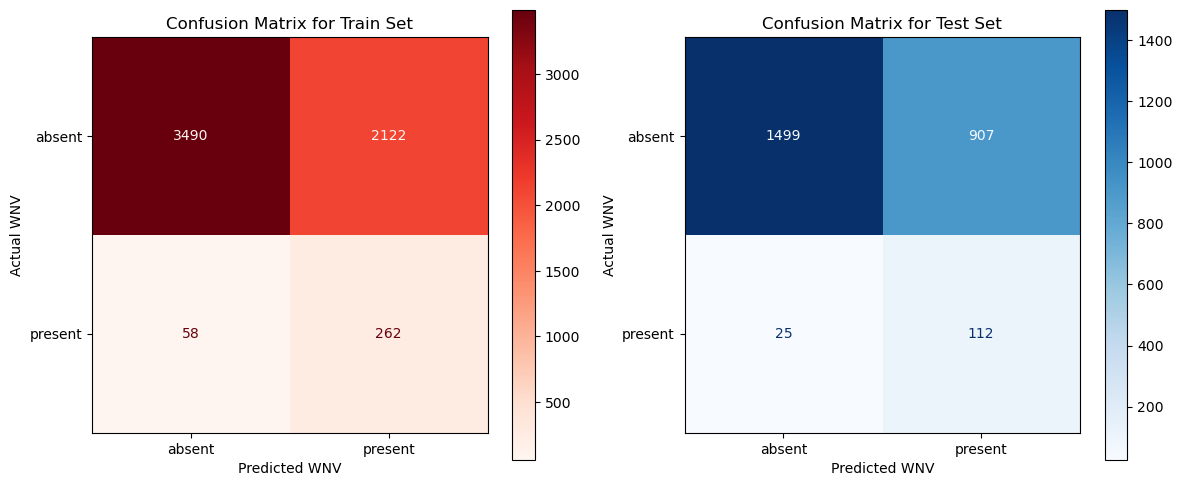

In [113]:
# Plot Confusion Matrix (Train and Test)

cmplot(NB)

### 1.6.3 Decision Tree [Baseline Model]

In [26]:
# Define parameter grid

param_grid_dt = {
    'clf': [DecisionTreeClassifier()],
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [None, 10, 50],  # Picking just the smallest, largest, and None
    'clf__min_samples_split': [2, 10],  # Just the smallest and largest
    'clf__min_samples_leaf': [1, 4],  # Again, smallest and largest
    'clf__max_features': [None, 'sqrt'],  # 'auto' is equivalent to 'sqrt'
    'clf__class_weight': [None, 'balanced']
}

In [27]:
%time
# Run grid search

grid_search_dt = run_grid_search(pipeline, param_grid_dt, X_train, y_train)
print("Best parameters for Decision Trees:", grid_search_dt.best_params_)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.86 µs
Fitting 10 folds for each of 96 candidates, totalling 960 fits
Best parameters for Decision Trees: {'clf': DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       max_features='sqrt', min_samples_split=10), 'clf__class_weight': 'balanced', 'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10}


In [28]:
# Save the model

DT = grid_search_dt.best_estimator_

In [91]:
# Generate ROC_AUC scores

roc_auc(DT)

ROC-AUC for Train: 0.8993752227369921
ROC-AUC for Test: 0.742166784984012


In [104]:
# Generate Classifcation Reports

report(DT)

Classification Report for Train:
               precision    recall  f1-score   support

           0       0.98      0.84      0.90      5612
           1       0.20      0.74      0.32       320

    accuracy                           0.83      5932
   macro avg       0.59      0.79      0.61      5932
weighted avg       0.94      0.83      0.87      5932


Classification Report for Test:
               precision    recall  f1-score   support

           0       0.97      0.82      0.89      2406
           1       0.15      0.55      0.23       137

    accuracy                           0.81      2543
   macro avg       0.56      0.68      0.56      2543
weighted avg       0.93      0.81      0.85      2543



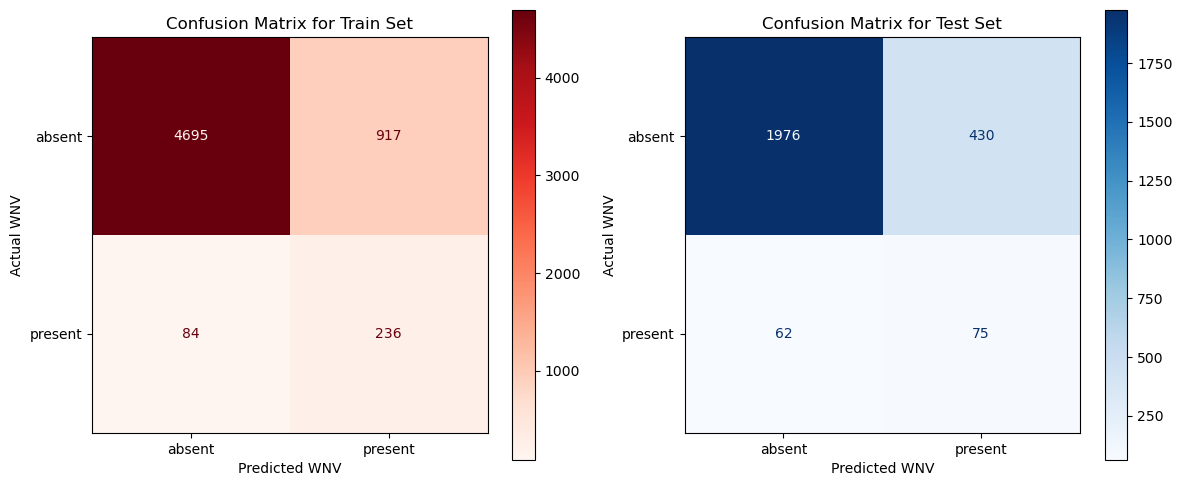

In [114]:
# Plot Confusion Matrix (Train and Test)

cmplot(DT)

### 1.6.4 K-Nearest Neighbour

In [32]:
param_grid_knn = {
    'clf': [KNeighborsClassifier()],
    'clf__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'clf__weights': ['uniform', 'distance'],
    'clf__metric': ['euclidean', 'manhattan', 'minkowski'],
    'clf__p': [1, 2]  # This is used only when metric is 'minkowski'. p=1 is manhattan, p=2 is euclidean.
}

In [33]:
%time
# Run grid search

grid_search_knn = run_grid_search(pipeline, param_grid_knn, X_train, y_train)
print("Best parameters for K-Nearest Neighbour:", grid_search_knn.best_params_)

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 4.05 µs
Fitting 10 folds for each of 84 candidates, totalling 840 fits
Best parameters for K-Nearest Neighbour: {'clf': KNeighborsClassifier(metric='manhattan', n_neighbors=15, p=1), 'clf__metric': 'manhattan', 'clf__n_neighbors': 15, 'clf__p': 1, 'clf__weights': 'uniform'}


In [34]:
# Save the model

KN = grid_search_knn.best_estimator_

In [92]:
# Generate ROC_AUC scores

roc_auc(KN)

ROC-AUC for Train: 0.9648429147362794
ROC-AUC for Test: 0.8156555084308692


In [105]:
# Generate Classifcation Reports

report(KN)

Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      0.82      0.90      5612
           1       0.23      0.95      0.37       320

    accuracy                           0.83      5932
   macro avg       0.61      0.89      0.64      5932
weighted avg       0.96      0.83      0.87      5932


Classification Report for Test:
               precision    recall  f1-score   support

           0       0.98      0.81      0.88      2406
           1       0.17      0.69      0.27       137

    accuracy                           0.80      2543
   macro avg       0.57      0.75      0.58      2543
weighted avg       0.94      0.80      0.85      2543



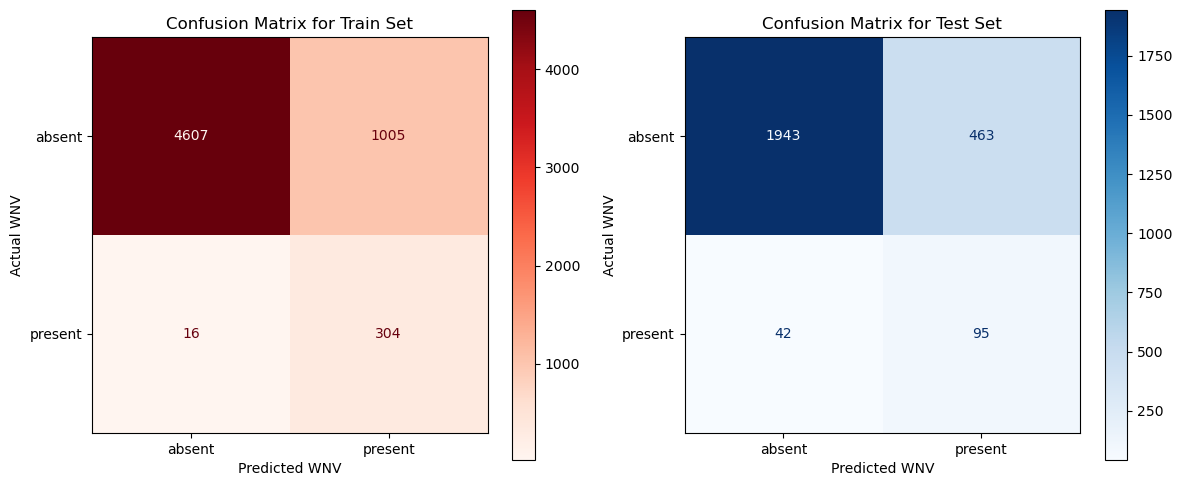

In [115]:
# Plot Confusion Matrix (Train and Test)

cmplot(KN)

### 1.6.5 Random Forest

In [38]:
param_grid_rf = {
    'clf': [RandomForestClassifier()],
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__bootstrap': [True, False]
}

In [39]:
%time
# Run grid search

grid_search_rf = run_grid_search(pipeline, param_grid_rf, X_train, y_train)
print("Best parameters for Random Forest:", grid_search_rf.best_params_)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 1.91 µs
Fitting 10 folds for each of 32 candidates, totalling 320 fits
Best parameters for Random Forest: {'clf': RandomForestClassifier(max_depth=20, min_samples_leaf=2), 'clf__bootstrap': True, 'clf__max_depth': 20, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


In [40]:
# Save the model

RF = grid_search_rf.best_estimator_

In [93]:
# Generate ROC_AUC scores

roc_auc(RF)

ROC-AUC for Train: 0.9936208125445474
ROC-AUC for Test: 0.8417581350759353


In [106]:
# Generate Classifcation Reports

report(RF)

Classification Report for Train:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      5612
           1       0.79      0.82      0.81       320

    accuracy                           0.98      5932
   macro avg       0.89      0.90      0.90      5932
weighted avg       0.98      0.98      0.98      5932


Classification Report for Test:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96      2406
           1       0.27      0.31      0.29       137

    accuracy                           0.92      2543
   macro avg       0.62      0.63      0.62      2543
weighted avg       0.92      0.92      0.92      2543



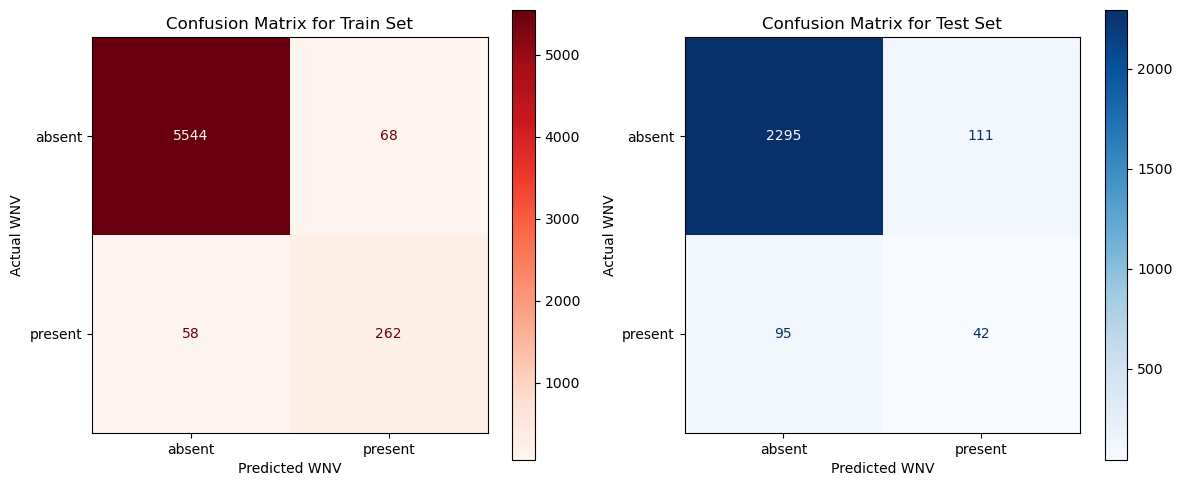

In [116]:
# Plot Confusion Matrix (Train and Test)

cmplot(RF)

### 1.6.6 AdaBoost

In [44]:
param_grid_ada = {
    'clf': [AdaBoostClassifier()],
    'clf__n_estimators': [10, 50, 100, 200],
    'clf__learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0],
    'clf__algorithm': ['SAMME', 'SAMME.R']
}

In [45]:
%time
# Run grid search

grid_search_ada = run_grid_search(pipeline, param_grid_ada, X_train, y_train)
print("Best parameters for AdaBoost:", grid_search_ada.best_params_)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.86 µs
Fitting 10 folds for each of 40 candidates, totalling 400 fits
Best parameters for AdaBoost: {'clf': AdaBoostClassifier(algorithm='SAMME', n_estimators=200), 'clf__algorithm': 'SAMME', 'clf__learning_rate': 1.0, 'clf__n_estimators': 200}


In [46]:
# Save the model

AD = grid_search_ada.best_estimator_

In [94]:
# Generate ROC_AUC scores

roc_auc(AD)

ROC-AUC for Train: 0.8584353283143265
ROC-AUC for Test: 0.842777484512563


In [107]:
# Generate Classifcation Reports

report(AD)

Classification Report for Train:
               precision    recall  f1-score   support

           0       0.97      0.90      0.93      5612
           1       0.22      0.51      0.31       320

    accuracy                           0.88      5932
   macro avg       0.60      0.70      0.62      5932
weighted avg       0.93      0.88      0.90      5932


Classification Report for Test:
               precision    recall  f1-score   support

           0       0.97      0.90      0.93      2406
           1       0.22      0.50      0.31       137

    accuracy                           0.88      2543
   macro avg       0.60      0.70      0.62      2543
weighted avg       0.93      0.88      0.90      2543



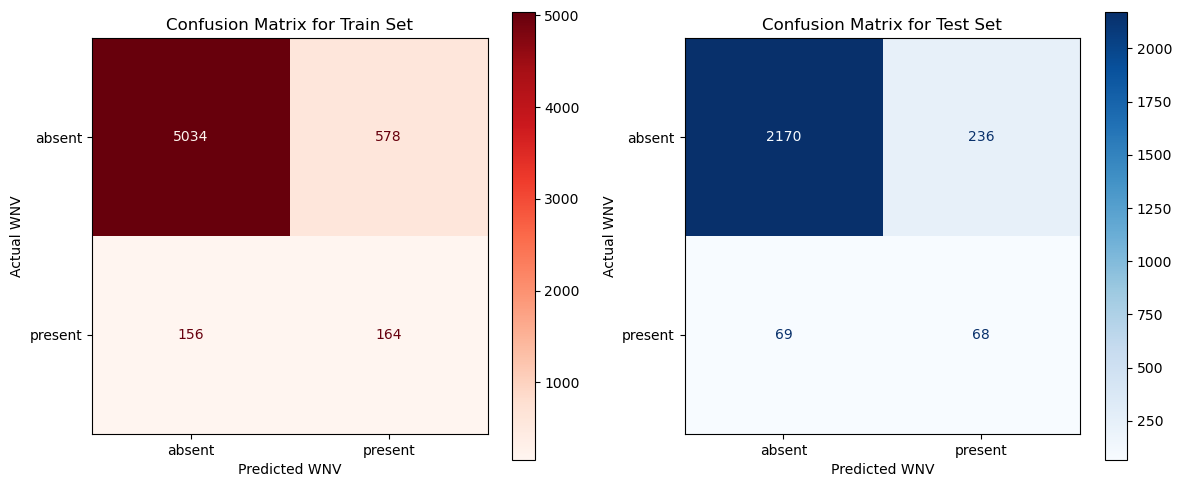

In [117]:
# Plot Confusion Matrix (Train and Test)

cmplot(AD)

### 1.6.7 Light GBM

In [50]:
# Define the parameter grid
param_grid_lg = {
    'clf': [LGBMClassifier()],
    'clf__objective': ['binary'],
    'clf__metric': ['auc'],
    'clf__boosting_type': ['gbdt'],
    'clf__num_leaves': [5],
    'clf__feature_fraction': [0.3, 0.5, 0.7],
    'clf__bagging_fraction': [0.3, 0.5, 0.7],
    'clf__bagging_freq': [10, 20, 30],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__lambda_l1': [0, 0.1, 0.5],  # L1 regularization
    'clf__lambda_l2': [0, 0.1, 0.5],  # L2 regularization
    'clf__verbose': [-1],  # Suppress LightGBM's verbosity
    'clf__silent': [True]  # Make LightGBM quiet
}

In [51]:
%time
# Run grid search

grid_search_lg = run_grid_search(pipeline, param_grid_lg, X_train, y_train)
print("Best parameters for Light GBM:", grid_search_lg.best_params_)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 2.15 µs
Fitting 10 folds for each of 729 candidates, totalling 7290 fits
Best parameters for Light GBM: {'clf': LGBMClassifier(bagging_fraction=0.5, bagging_freq=10, feature_fraction=0.3,
               lambda_l1=0.5, lambda_l2=0, metric='auc', num_leaves=5,
               objective='binary', silent=True, verbose=-1), 'clf__bagging_fraction': 0.5, 'clf__bagging_freq': 10, 'clf__boosting_type': 'gbdt', 'clf__feature_fraction': 0.3, 'clf__lambda_l1': 0.5, 'clf__lambda_l2': 0, 'clf__learning_rate': 0.1, 'clf__metric': 'auc', 'clf__num_leaves': 5, 'clf__objective': 'binary', 'clf__silent': True, 'clf__verbose': -1}


In [132]:
# Save the model

LG = grid_search_lg.best_estimator_

In [133]:
# Generate ROC_AUC scores

roc_auc(LG)

ROC-AUC for Train: 0.8765911773877405
ROC-AUC for Test: 0.8448374198324142


In [134]:
# Generate Classifcation Reports

report(LG)

Classification Report for Train:
               precision    recall  f1-score   support

           0       0.97      0.92      0.94      5612
           1       0.27      0.50      0.35       320

    accuracy                           0.90      5932
   macro avg       0.62      0.71      0.65      5932
weighted avg       0.93      0.90      0.91      5932


Classification Report for Test:
               precision    recall  f1-score   support

           0       0.97      0.92      0.94      2406
           1       0.24      0.43      0.31       137

    accuracy                           0.89      2543
   macro avg       0.60      0.68      0.62      2543
weighted avg       0.93      0.89      0.91      2543



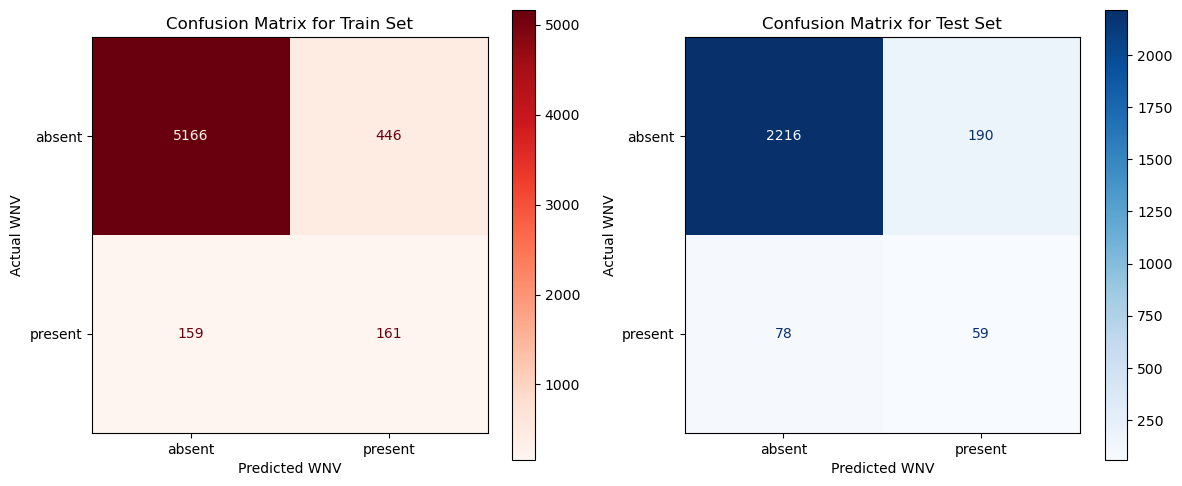

In [135]:
# Plot Confusion Matrix (Train and Test)

cmplot(LG)

### 1.6.8 XGBoost

In [56]:
param_grid_xgb = {
    'clf': [XGBClassifier()],
    'clf__learning_rate': [0.01, 0.1],
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [3, 7],
    'clf__min_child_weight': [1, 5],
    'clf__gamma': [0, 0.1],
    'clf__subsample': [0.8, 1.0],
    'clf__colsample_bytree': [0.8, 1.0],
    'clf__objective': ['binary:logistic']
}

In [57]:
%time
# Run grid search

grid_search_xgb = run_grid_search(pipeline, param_grid_xgb, X_train, y_train)
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 5.25 µs
Fitting 10 folds for each of 128 candidates, totalling 1280 fits
Best parameters for XGBoost: {'clf': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), 'clf__colsample_bytree': 0.8, 'clf__gamma': 0.1, 'clf__learning_rate': 0.1, 'clf__max_

In [58]:
# Save the model

XG = grid_search_xgb.best_estimator_

In [96]:
# Generate ROC_AUC scores

roc_auc(XG)

ROC-AUC for Train: 0.9409688502316466
ROC-AUC for Test: 0.8475283809939871


In [109]:
# Generate Classifcation Reports

report(XG)

Classification Report for Train:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      5612
           1       0.46      0.61      0.52       320

    accuracy                           0.94      5932
   macro avg       0.72      0.78      0.75      5932
weighted avg       0.95      0.94      0.94      5932


Classification Report for Test:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      2406
           1       0.32      0.45      0.37       137

    accuracy                           0.92      2543
   macro avg       0.65      0.70      0.67      2543
weighted avg       0.93      0.92      0.93      2543



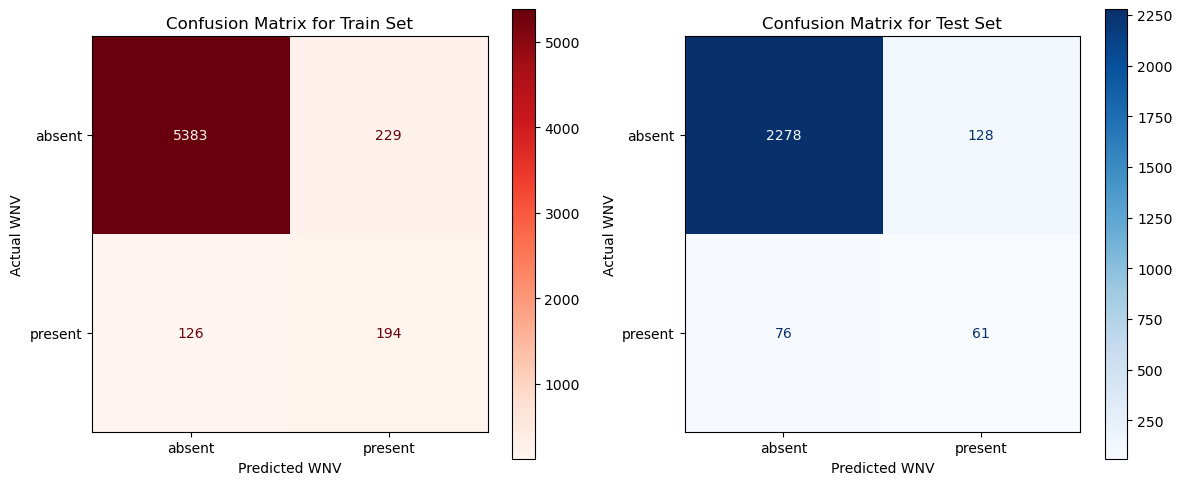

In [119]:
# Plot Confusion Matrix (Train and Test)

cmplot(XG)

### 1.6.9 Support Vector Machine (SVM) Classifier

In [62]:
param_grid_svm = {
    'clf': [SVC(probability=True)],
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['rbf'],
    'clf__gamma': ['scale', 1]
}

In [63]:
%time
# Run grid search

grid_search_svm = run_grid_search(pipeline, param_grid_svm, X_train, y_train)
print("Best parameters for SVM:", grid_search_svm.best_params_)

CPU times: user 3 µs, sys: 4 µs, total: 7 µs
Wall time: 2.86 µs
Fitting 10 folds for each of 6 candidates, totalling 60 fits


/Users/miskhander/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for SVM: {'clf': SVC(C=0.1, probability=True), 'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}


In [64]:
# Save the model

SV = grid_search_svm.best_estimator_

In [98]:
# Generate ROC_AUC scores

roc_auc(SV)

ROC-AUC for Train: 0.8888063524590164
ROC-AUC for Test: 0.8430626596525718


In [110]:
# Generate Classifcation Reports

report(SV)

Classification Report for Train:
               precision    recall  f1-score   support

           0       0.99      0.75      0.85      5612
           1       0.17      0.88      0.28       320

    accuracy                           0.76      5932
   macro avg       0.58      0.82      0.57      5932
weighted avg       0.95      0.76      0.82      5932


Classification Report for Test:
               precision    recall  f1-score   support

           0       0.99      0.76      0.86      2406
           1       0.16      0.82      0.27       137

    accuracy                           0.76      2543
   macro avg       0.57      0.79      0.56      2543
weighted avg       0.94      0.76      0.83      2543



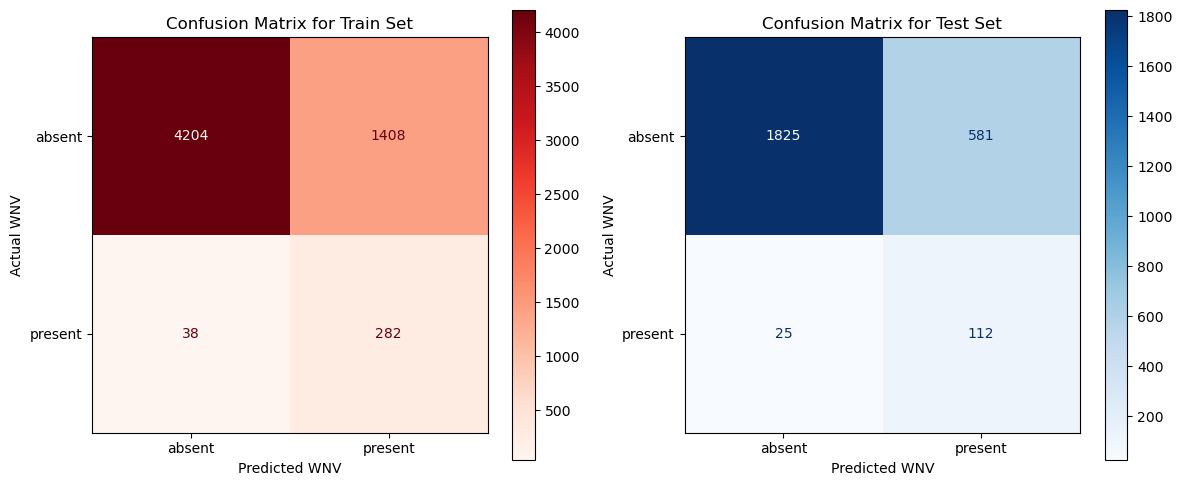

In [120]:
# Plot Confusion Matrix (Train and Test)

cmplot(SV)

# 2.0 Findings and conclusion

## 2.1 Summary of Results

| Model                   | Train | Test |
|-------------------------|-------|------|
| <b>Light GBM</b>        | 0.88  | 0.84 |
| XGBoost                 | 0.95  | 0.85 |
| Random Forest           | 0.99  | 0.84 |
| Support Vector Machine  | 0.89  | 0.84 |
| AdaBoost                | 0.86  | 0.84 |
| K-Nearest Neighbors     | 0.96  | 0.82 |
| Logistic Regression     | 0.80  | 0.80 |
| Gaussian Naive Bayes    | 0.79  | 0.79 |
| Decision Trees          | 0.89  | 0.78 |

The chosen model is <b>Light GBM</b> with a test ROC-AUC score of 0.84.

## 2.2 Kaggle Submission

We will submit the top 2 test scores since they have similar roc_auc scores.

### 2.2.1 Create Function to Submit to Kaggle

In [121]:
def submit(merge_test, X, model, name):
    df = merge_test

    # Ensure merge_test only has columns present in X
    for col in df.columns:
        if col not in X.columns:
            df.drop(col, axis=1, inplace=True)

    # Ensure merge_test has all columns present in X, fill with 0 if not
    for col in X.columns:
        if col not in df.columns:
            df[col] = 0

    # Reorder columns in merge_test to match order in X
    df = df[X.columns]

    scaler = model.named_steps['ss']
    df_scaled = scaler.transform(df)
    preds = model.predict_proba(df)[:, 1]

    submission_df = df.copy()
    submission_df['wnvpresent'] = preds
    submission_df['id'] = range(1, len(submission_df) + 1)
    submission_df[['id', 'wnvpresent']].to_csv(f"../submissions/kaggle_submission_{name}.csv", index=False)

### 2.2.2 XGBoost

In [123]:
submit(merge_test, X, grid_search_xgb.best_estimator_, "xgb")

![XGB](../images/kaggle_xgb_score.png)

### 2.2.3 Light GBM

In [125]:
submit(merge_test, X, grid_search_lg.best_estimator_, "lg")

![LGBM](../images/kaggle_light_score.png)

## 2.3 Feature Importances & ROC Curve

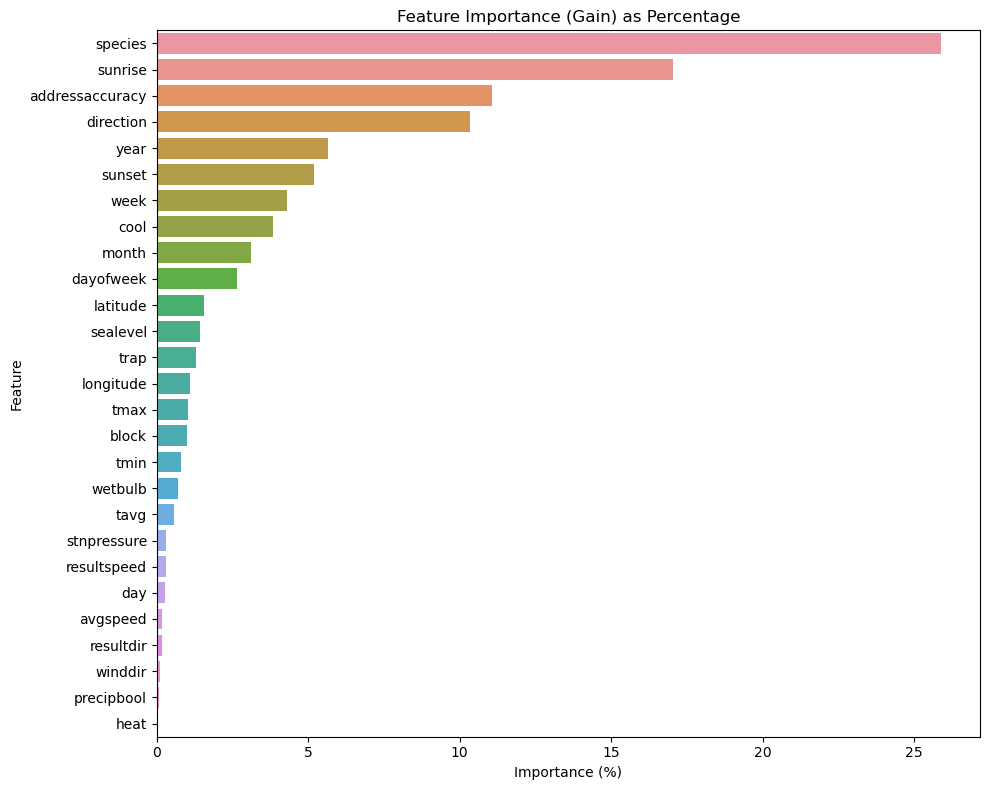

In [136]:
# Plot feature importances by value

best_lgbm = grid_search_lg.best_estimator_.named_steps['clf']

gain_importance = best_lgbm.booster_.feature_importance(importance_type='gain')

total_importance = sum(gain_importance)

importance_percentage = [(imp / total_importance) * 100 for imp in gain_importance]

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance (%)': importance_percentage
})

importance_df = importance_df.sort_values(by='Importance (%)', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance (%)', y='Feature', data=importance_df)
plt.title('Feature Importance (Gain) as Percentage')
plt.tight_layout()
plt.show()

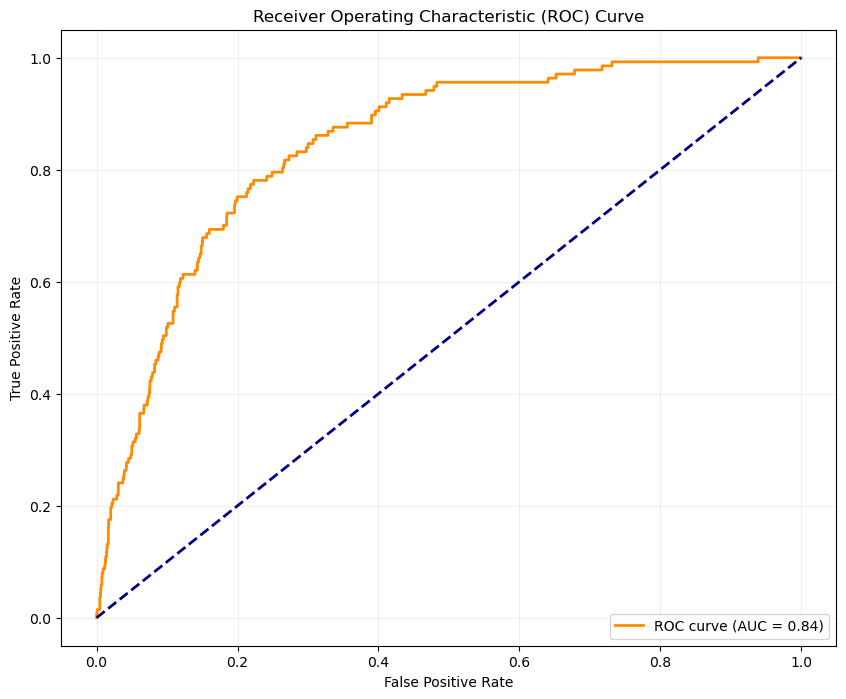

In [139]:
# Plot ROC curve

model = grid_search_lg.best_estimator_
y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.2)
plt.show()

## 2.4 Conclusion

### 2.4.1 Recommendations 

The top 5 features are species, sunrise, addressaccuracy, direction and year.

**Species:**   
Certain mosquito species like Culex Pipiens and Culex Restuans are more likely to carry the virus. Targeting their breeding grounds and spraying them may help to reduce the presence of west nile virus.   

**Sunrise:**   
Sunrise times can affect daylight hours which may in turn affect mosquito activity and breeding patterns. This information can be used to time sprayings to coincide with peak mosquito activity periods.   

**AddressAccuracy:**   
This feature suggests that areas with higher geolocation accuracy may be associated with more reliable data on WNV cases. This can lead to more effective targeting of resources.   

**Direction:**   
To recap, direction is an engineered feature that captures the direction of the street. The orientation of the street may affect wind patterns and/or exposure to sunlight. Understanding these patterns may help in predicting outbreak locations and allow the health deapartment to focus on preventive measures.   

**Year:**   
The year could show the effectiveness of spraying.

### 2.4.2 Cost Benefit Analysis

#### 2.4.2.1 Cost of Spray = Cost of Spraying Per Area * Land Area * Frequency

Cost of Spraying Zenivex E20 (Insecticide) per area = USD 0.67 / acre   
Total land area in Chicago  = 148,300 acres   
No. of Sprays per year = 12   
Total Cost of Spraying per year = USD 1.2MM   

#### 2.4.2.2 Cost of Traps = No. of Traps * Cost of Each Trap

No. of Traps (from dataset) = 149   
Median cost per Gravid Trap (incl maintenance) = 300 USD   
Total Cost of Traps per year = USD 45K    

Total Costs = USD 1.25MM   

#### 2.4.2.3 Derived Benefits

Benefits are derived from the potential savings from:   
1. Loss in Productivity / Income
2. Medical Bills if individuals are kept free from WnV





![Benefits](../images/benefits.png)

#### 2.4.2.4 Overall Cost Benefit Analysis

|                                        | CURRENT APPROACH      | MODEL DRIVEN APPROACH |
|----------------------------------------|-----------------------|-----------------------|
| **COST OF SPRAYING**                   | -1.2 MM USD (entire Chicago) | -0.0052 MM USD                       |
| **COST OF TRAPS**                      | -0.045 MM USD         | -0.045 MM USD         |
| **BENEFITS FROM MEDICAL BILLS + PRODUCTIVITY** | +56MM USD          | +56MM USD             |
| **NET BENEFIT**                        | +55MM USD             | +56MM USD                      |
